# 3 - Preprocessing & Exploratory Data Analysis

Now that we have the text out of our document sample, we can start to break down the text further with preprocessing, and start to explore the variations and patterns in our dataset.

There are a number of standard checks and explorations we want to look at as part of a natural language processing project, including distributions of length of documents, sentences, special characters. We also want to make some comparisons against metadata characteristics, to be aware of any trends or correlations that we should be aware of in our corpus.

At the end of the EDA process, we want to have a better understanding of the contents and patterns in the corpus. If we go into the modeling process blind to the content of our dataset, we are going to take ineffective modeling or statistical approaches. Or, we may inadvertently make choices or mistakes that could have been avoided if we better understood the characteristics and limitations of our corpus.


In [1]:
import os
import spacy
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from typing import List, Set, Dict, Tuple
from dotenv import load_dotenv

<br/>

Set home directory - we suggest making this the data folder in the repo:

In [2]:
load_dotenv()
HOME_DIRECTORY = os.getenv("HOME_DIRECTORY")

<br/><br/><br/>

## Segment Sentences

Let's first ingest our OCR extraction results, and segment the text data into individual sentences.

In [3]:
def read_text_files(folder_path: str):
    """
    Read text from a folder of .txt files.

    Parameters:
    - folder_path (str): Path to the folder containing .txt files.

    Returns:
    - texts (list): List of strings, where each string is the content of a text file.
    """
    texts = []
    files = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                texts.append(text)
                files.append(filename)

    return texts, files

def process_texts_to_dataframe(texts: List, filenames: List):
    """
    Tokenize sentences in a list of texts and save the results in a Pandas DataFrame.

    Parameters:
    - texts (list): List of texts to be processed.
    - filenames (list): List of corresponding filenames.

    Returns:
    - df (DataFrame): Pandas DataFrame containing columns: 'filename', 'sentence_index', 'sentence_text'.
    """
    nlp = spacy.load('en_core_web_sm', exclude=["parser"])
    config = {"punct_chars": ['\n\n', '.', '?', '!']}
    nlp.add_pipe("sentencizer", config=config)
    
    data = {'filename': [], 'sentence_index': [], 'sentence_text': []}

    for filename, text in zip(filenames, texts):
        for i, sentence in enumerate(nlp(text).sents):
            data['filename'].append(filename)
            data['sentence_index'].append(i)
            data['sentence_text'].append(sentence.text)

    df = pd.DataFrame(data)
    return df


In [4]:
folder_path = os.path.join(HOME_DIRECTORY, "data", "data_text")
texts, filenames = read_text_files(folder_path)
sentences_df = process_texts_to_dataframe(texts, filenames)
sentences_df.head()

,filename,sentence_index,sentence_text
0,00002MGK.pdf.txt,0,Modification Summary Report\n\n
1,00002MGK.pdf.txt,1,Conteact (PO) Number: 1406\nModification Revis...
2,00002MGK.pdf.txt,2,Specification Number: 3858\n\n
3,00002MGK.pdf.txt,3,Name of Contractor: GLOBETROTTERS ENGINEERING ...
4,00002MGK.pdf.txt,4,City Department: DEPARTMENT OF CONSTRUCTION AN...


<br/><br/>

Given that the processing can take a while, we will save the results to a pickle file so that we don't have to re-run this code again unnecessarily:

In [8]:
# sentences_df.to_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'corpus_sentences.pkl'))

Once it's saved, we can load our results back in quickly rather than re-running the code.

*Note*: As with all large files, you may also pull this pickled file from the Google drive.

In [5]:
# Once saved, read the DataFrame from the Pickle file
sentences_df = pd.read_pickle(os.path.join(HOME_DIRECTORY, 'data', 'data_pickles', 'corpus_sentences.pkl'))

# Display the loaded DataFrame
sentences_df

,filename,sentence_index,sentence_text
0,Kindlyex10-1.htm,0,EX-10.1 2 ex10-1.htm Exhibit\n10.1 CERTAIN\nSC...
1,Kindlyex10-1.htm,1,THE COMPANY\nAGREES TO FILE SUPPLEMENTALLY TO ...
2,Kindlyex10-1.htm,2,OMITTED SCHEDULES AND INFORMATION ARE REPRESEN...
3,Kindlyex10-1.htm,3,"Kindly\nMD, INC."
4,Kindlyex10-1.htm,4,BOARD\nOF DIRECTORS - RETAINER AGREEMENT This\...
...,...,...,...
967944,00002QKJ.pdf.txt,50,Het 7\n\n‘
967945,00002QKJ.pdf.txt,51,Subscribed and swom to before me thus 2/ 5+\n\n
967946,00002QKJ.pdf.txt,52,"Day of Decemuhers 2006\n_ “opriciat seat""\nNot..."
967947,00002QKJ.pdf.txt,53,"ay Soman Eres No 8 2008,\n\n‘"


<br/><br/>

## Exploratory Data Analysis

Let's start walking through some standard checks as part of our exploratory data analysis. It's helpful to explore the corpus at the document level and sentence level.

<br/>

### Document Distributions

One initial set of checks is to simply look at the overall distribution of document length across the corpus, as well as the distribution of the sentence lengths.

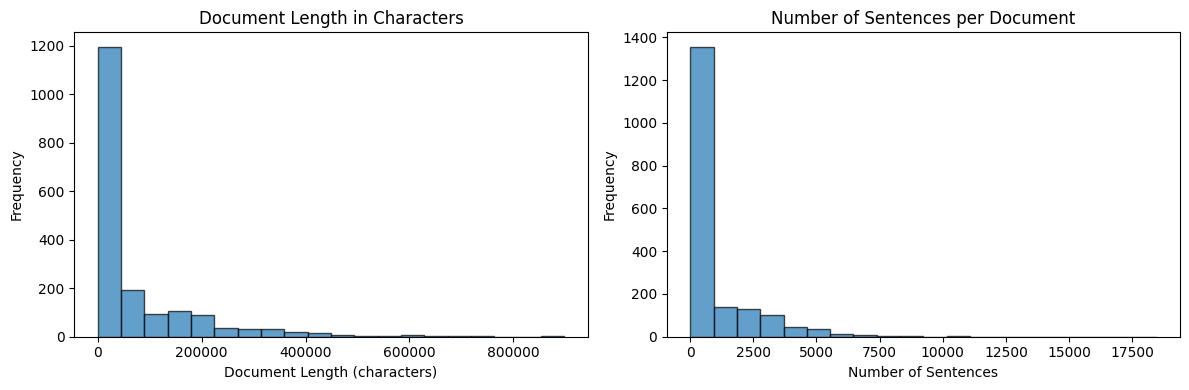

In [6]:
def plot_document_length_histograms(texts: List, dataframe):
    """
    Plot side-by-side histograms of document lengths in characters and sentences per document.

    Parameters:
    - texts (list): List of documents (strings).
    - dataframe (DataFrame): Pandas DataFrame with columns 'filename' and 'sentence_text'.

    Returns:
    None
    """
    # Calculate document lengths in characters and sentences
    dataframe['document_length_chars'] = dataframe['sentence_text'].apply(lambda x: len(x))
    dataframe['sentence_count'] = dataframe['sentence_text'].apply(lambda x: len(x.split('.')))

    # Group by filename and aggregate document lengths
    grouped_data = dataframe.groupby('filename').agg({
        'document_length_chars': 'sum',
        'sentence_count': 'sum'
    }).reset_index()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot histogram of document lengths in characters
    axes[0].hist(grouped_data['document_length_chars'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_title('Document Length in Characters')
    axes[0].set_xlabel('Document Length (characters)')
    axes[0].set_ylabel('Frequency')

    # Plot histogram of document lengths in sentences
    axes[1].hist(grouped_data['sentence_count'], bins=20, edgecolor='black', alpha=0.7)
    axes[1].set_title('Number of Sentences per Document')
    axes[1].set_xlabel('Number of Sentences')
    axes[1].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    return grouped_data

corpus_lengths = plot_document_length_histograms(texts, sentences_df)

<br/>
As we explore a new corpus, we want to make sure our data is making logical and business sense. Why would there be a document with zero sentences or a character length of zero? What is going on with the outlier at 600,000 characters?

In [7]:
corpus_lengths[['filename', 'document_length_chars']].sort_values('document_length_chars')

,filename,document_length_chars
1211,filename6.htm,36
1564,{3648F9D4-6EBB-4789-A865-A236D2FB3239}.pdf.txt,854
1719,{AA465F2E-E554-49D6-8116-948C8B5AE456}.pdf.txt,1018
969,ea021197601ex10-1i_silexion.htm,1028
1568,{3705C921-2477-425E-8EA5-C4977C4F5885}.pdf.txt,1049
...,...,...
1314,servicesagreement-executio.html,664433
1253,lmrk-ex41_8.htm,714816
1196,exhibit41-plnt2024x1xsup.html,756269
741,appfolioliveeasy-mergera.html,866739


<br/>

Based on this, let's explore a very short document such as "{3648F9D4-6EBB-4789-A865-A236D2FB3239}.pdf.txt" as well as one of the very long documents such as "{CAE88AA3-9DC3-49B7-87E6-D0D8AA8371FB}.pdf.txt"

We want to make sure the documents at the extreme ends are valid and make sense.

In [8]:
filename = '{CAE88AA3-9DC3-49B7-87E6-D0D8AA8371FB}.pdf.txt'
with open(os.path.join(HOME_DIRECTORY, 'data', 'data_text', filename), 'r', encoding='utf-8') as file:
    text = file.read()

text

'Contract Sumi cel\n\nContract (PO) Number: 82557\nSpecification Number: 378933\n\n[Name of Contractor: SUMIT CONSTRUCTION CO, INC.\nCity Department: DEPT OF AVIATION\n\nTitle of Contract: 1ANDSIDE CONCRETE, MAINTENANCE, REPAIR AND.\nREPLACEMENT AT OHARE AND MIDWAY INTERNATIONAL\nAIRPORTS (SPEC #378933)\n\n‘Term of Contract: Start Date: 3/1/2019\nEnd Date: 2/29/2024\n\nDollar Amount of Contract (or maximum compensation ifa Term Agreement) (DUR):\n$22,529,000.00\n\nBrief Description of Work: LANDSIDE CONCRETE, MAINTENANCE, REPAIR AND.\nREPLACEMENT AT OHARE AND MIDWAY\nINTERNATIONAL AIRPORTS (SPEC #378933)\n\nProcurement Serviees Contract Area: WORK SERV-AVIATION\n\nPlease refer tothe DPS website or Contact information under "Doing Business With The City".\n\n‘Vendor Number: 1004913\nSubmission Date: 10162018\nevra oyu evra\n\n1004013 ‘Sumi Conetrustion Co ne 82867\n\nLandside Concrete Maintenance, Repair and Replacement\nat O’Hare and Midway International Airports\n\nspecication Number:

In [9]:
filename = '{3648F9D4-6EBB-4789-A865-A236D2FB3239}.pdf.txt'
with open(os.path.join(HOME_DIRECTORY, 'data', 'data_text', filename), 'r', encoding='utf-8') as file:
    text = file.read()

text

'Contract (PO) Number: 26588\nModification Revision Number: 7\n‘Specification Number: 85907 A\n\nMESSENGER SERVICES\n\n‘Mod Rea Number ‘Mod Reason Description\nPO-# 26588 Amow Messenger\n268754 TIME EXTENSION Service 1-Veu Extension Option\n2019-2020\n\nProcurement Services Contact Person: MAGDALENA TOUSSAINT\nPlease refer tothe DPS website for Contact information under "Doing Business With The Cty".\n\nIthas been determined, on behalf ofthe City of Chicago, with regard to this Contract Amendment\n“Modification, that the circumstance said to necessitate the change in performance were not\nreasonably foreseeable at the time the Agreement was signed, or that the change is germane to the\n‘original Agreement as signed, or that the change order is inthe best interest ofthe City of Chicago\nand is authorized by law\n\n‘Vendor Number: 1000030\n\nSubmission Date: Cf, |. 1\n'

<br/><br/>

Let's also look at the PDFs themselves to double check -- first our document with 615,218 sentences:

<div>
<img src="../data/resources/{CAE88AA3-9DC3-49B7-87E6-D0D8AA8371FB}.pdf.png" width="300"/>
</div>

<br/>

Turns out this is a 237 page document, whose table of contents alone is over 10 pages long! At a glance through the PDF, the document looks valid.

Now let's check out the short document:

<div>
<img src="../data/resources/{3648F9D4-6EBB-4789-A865-A236D2FB3239}.pdf.png" width="300"/>
</div>

<br/>

This document is a 1-pager modification summary, and also looks to be valid.

While these couple of cases turned out to give us valid documents, these types of checks can often turn up problem documents - where OCR didn't run correctly due to rotation, or where the image contrast is too light, or a corrupted document, or a variety of other issues.

<br/><br/>

### Exercise 3.1

Repeat the exploration of documents for those with very few or many sentences to assess potential data quality issues.

<br/><br/>

Another helpful exploration is to look at the amount of special characters - this can sometimes be indicative of OCR issues or errors.

In [10]:
def calculate_special_character_percentage(texts: List):
    """
    Calculate the percent of special characters in each document in a given corpus.

    Parameters:
    - texts (list): List of documents (strings).

    Returns:
    - percentages (list): List of percentages of special characters in each document.
    """
    percentages = []

    for text in texts:
        # Count total characters and special characters
        total_chars = len(text)
        special_chars = sum(1 for char in text if not char.isalnum() and char not in ['\n', ' '])
        # print([char for char in text if not char.isalnum() and char not in ['\n', ' ']][:30])

        # Calculate the percentage of special characters
        percentage = (special_chars / total_chars) * 100 if total_chars > 0 else 0
        percentages.append(percentage)

    return percentages

def plot_special_character_distribution(percentages: List):
    """
    Plot a histogram of the distribution of special character percentages.

    Parameters:
    - percentages (list): List of percentages of special characters in each document.

    Returns:
    None
    """
    # Plot the histogram
    plt.hist(percentages, bins=20, edgecolor='black', alpha=0.7)
    
    # Set labels and title
    plt.title('Distribution of Special Character Percentages')
    plt.xlabel('Percent of Special Characters')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

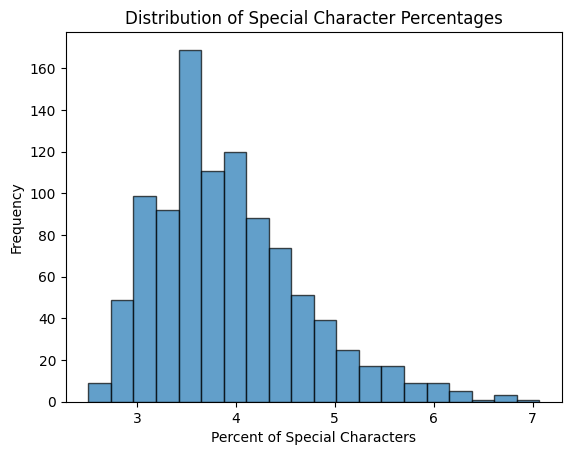

In [11]:
special_char_percentages = calculate_special_character_percentage(texts)
plot_special_character_distribution(special_char_percentages)

<br/><br/>

### Exercise 3.2

Explore if there is a correlation between the OCR quality metrics and the special character rate at the document level and at the sentence level.

<br/><br/>
### Sentence Distributions

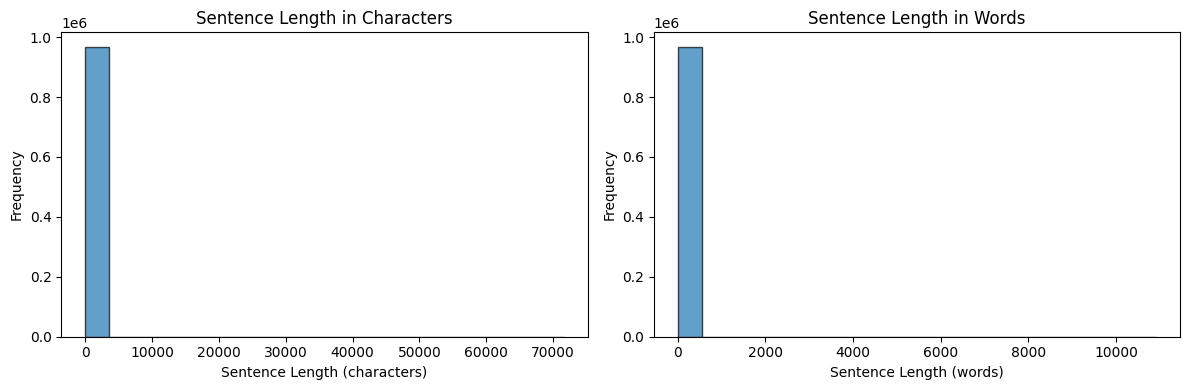

In [12]:
def plot_sentence_length_histograms(dataframe, column_name: str):
    """
    Plot side-by-side histograms of sentence lengths in characters and words for a given column in a Pandas DataFrame.

    Parameters:
    - dataframe (DataFrame): The Pandas DataFrame.
    - column_name (str): The name of the column containing sentences.

    Returns:
    None
    """
    # Calculate sentence lengths in characters and words
    dataframe['sentence_length_chars'] = dataframe[column_name].apply(lambda x: len(x))
    dataframe['sentence_length_words'] = dataframe[column_name].apply(lambda x: len(x.split()))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot histogram of sentence lengths in characters
    axes[0].hist(dataframe['sentence_length_chars'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_title('Sentence Length in Characters')
    axes[0].set_xlabel('Sentence Length (characters)')
    axes[0].set_ylabel('Frequency')

    # Plot histogram of sentence lengths in words
    axes[1].hist(dataframe['sentence_length_words'], bins=20, edgecolor='black', alpha=0.7)
    axes[1].set_title('Sentence Length in Words')
    axes[1].set_xlabel('Sentence Length (words)')
    axes[1].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_sentence_length_histograms(sentences_df, 'sentence_text')

<br/><br/>

### Exercise 3.3

Explore if there is a correlation between the OCR quality metrics and the average sentence length across the documents.

<br/><br/>

### Exercise 3.4

Explore if there is a correlation between the OCR quality metrics and the date of the documents.

<br/>

### Visualization: Word Cloud

Although it is highly qualitative, it can sometimes be helpful to visualize the most common words in a corpus.

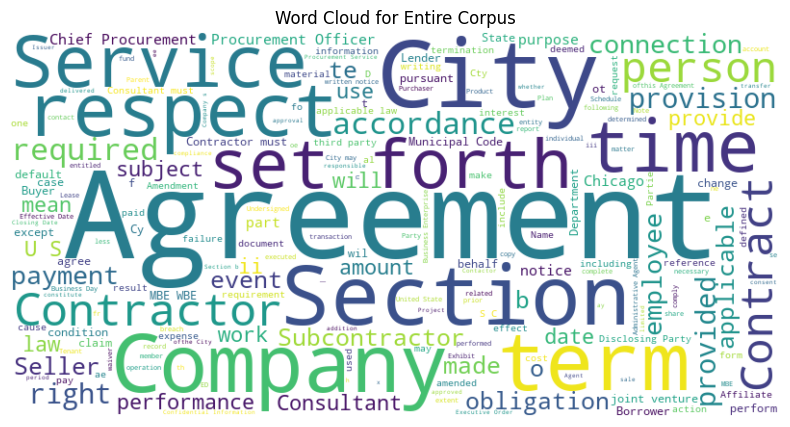

In [13]:
def generate_word_cloud(dataframe, column_name: str, title_string: str = 'Word Cloud for Entire Corpus'):
    """
    Generate and display a word cloud for a given column in a Pandas DataFrame.

    Parameters:
    - dataframe (DataFrame): The Pandas DataFrame.
    - column_name (str): The name of the column containing sentences.

    Returns:
    None
    """
    # Combine all sentences into a single string
    all_text = ' '.join(dataframe[column_name])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title_string)
    plt.show()

generate_word_cloud(sentences_df, 'sentence_text')

<br/><br/>

### Exercise 3.5

Generate additional word clouds for each of these subsets:
1. Master agreements
2. RFPs
3. Bids

Are there patterns or commonalities?

(*Hint*: Use the original CSV from notebook one to subset the data by filename)

<br/><br/><br/>